# Structured RerF Demo

Similar to figure 13 [here](https://arxiv.org/pdf/1506.03410v4.pdf) we create a 
distribution of 28x28 pixel images with randomly spaced and sized bars. 

In class 0 the bars are oriented horizontally and in class 1 the bars are oriented vertically.

We compare the error-counting estimator $\hat{L}_{n,m}$ for $n \in \{10, 20, \dots, 1000\}$ and $m=10000$ over S-RerF, RerF, and a few other classification algorithms. 

In [2]:
%matplotlib inline
import gc
import math
import pandas as pd
import numpy as np
import time, multiprocessing
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import seaborn as sns

from rerf.RerF import fastPredict, fastPredictPost, fastRerF
from rerf.rerfClassifier import rerfClassifier

from scipy.stats import bernoulli
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

gc.enable()

import warnings
warnings.simplefilter('ignore')

In [3]:
def genHV(h = 28, w = 28, lambda_ = 10, num_samples = 10, prob = 0.5):
    num_bars = np.random.poisson(lam = lambda_, size = num_samples)

    loc = [np.random.randint(0, h, nbi) for nbi in num_bars]
    
    #cls = bernoulli.rvs(p = prob, size = num_samples)
    #classLabel = [0 for _ in range(int(num_samples / 2))] +\
    #        [1 for _ in range(int(num_samples / 2))]

    # Y = [0,1,0,1,0,1,...]
    classLabel = [0,1] * int(num_samples / 2)

    out = []
    for i in range(num_samples):
        X = np.zeros(h * w).reshape(h, w)
        for j in loc[i]:
            X[j, :] = 1

        out.append(X)
            
    for ci in range(len(classLabel)):
        if classLabel[ci] == 1:
            out[ci] = np.transpose(out[ci])

    #out = np.asarray([outi.flatten() for outi in out])
    out = np.asarray([outi.flatten() for outi in out])

    return out, classLabel

In [4]:
rng = np.random.RandomState(4)

ns = np.array([10,50,100,200,400,1000,2000])

X_train, Y_train = genHV(num_samples = ns[-1])
X_test, Y_test = genHV(num_samples = 10000)

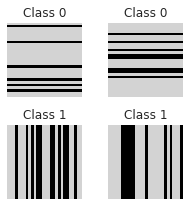

In [60]:
#plt.clf()
plt.figure(figsize=(3,3))
matplotlib.rcParams.update({'font.size': 11, 'xtick.labelsize': 11, 'ytick.labelsize': 11})

cmap = plt.cm.gray_r; cmap.set_under(color='lightgray')    

plt.subplot(2,2,1)
plt.imshow(X_train[0, :].reshape(28,28), cmap=cmap,vmin=0.5); plt.axis('off')
plt.title("Class 0")
plt.subplot(2,2,2)
plt.imshow(X_train[2, :].reshape(28,28), cmap=cmap,vmin=0.5); plt.axis('off')
plt.title("Class 0")
plt.subplot(2,2,3)
plt.imshow(X_train[1, :].reshape(28,28), cmap=cmap,vmin=0.5); plt.axis('off')
plt.title("Class 1")
plt.subplot(2,2,4)
plt.imshow(X_train[3, :].reshape(28,28), cmap=cmap,vmin=0.5); plt.axis('off')
plt.title("Class 1")
plt.tight_layout()
plt.savefig('../hvbar_sample.pdf',format='pdf', bbox_inches='tight')
plt.show()

In [19]:
## Setup for run
names = {"kNN": "black", 
         "RF":"#f86000", "MLP":"green", "RerF":"cyan", "CNN":"olive","S-RerF":"red"}

ncores=1
num_runs=1
n_est=100

classifiers = [
    #SVC(C=1.0, kernel='rbf', gamma='auto',random_state=0),
    KNeighborsClassifier(3, n_jobs=ncores),
    RandomForestClassifier(n_estimators=n_est, max_features=28, n_jobs=ncores),
    MLPClassifier(hidden_layer_sizes=(100, ), random_state=0, max_iter=500),
    rerfClassifier(n_estimators = n_est, projection_matrix = "RerF",
        max_features = 28, n_jobs = ncores),
    rerfClassifier(
        projection_matrix="S-RerF", 
        max_features = 28,
        n_estimators=n_est,
        n_jobs=ncores,
        image_height=28, 
        image_width=28, 
        patch_height_max=4,
        patch_width_max=1,
        patch_height_min=4,
        patch_width_min=1,
        )
    ]

In [5]:
## Setup for run, define classifiers to train and test
names = {"Log. Reg": "#a6cee3", 
         "Lin. SVM":"#1f78b4", 
         "SVM":"#b2df8a", 
         "kNN": "#33a02c", 
         "RF":"#fb9a99", 
         "MLP":"#fdbf6f", 
         "RerF":"#ff7f00", 
         "S-RerF":"#e31a1c",
         "CNN":"#cab2d6"}
ncores=1
num_runs=1
n_est=100

classifiers = [
    LogisticRegression(random_state=0, n_jobs=ncores, solver='liblinear'),
    LinearSVC(),
    SVC(C=1.0, kernel='rbf', gamma='auto',random_state=0),
    KNeighborsClassifier(3, n_jobs=ncores),
    RandomForestClassifier(n_estimators=n_est, max_features='auto', n_jobs=ncores),
    MLPClassifier(hidden_layer_sizes=(100, ), random_state=0, max_iter=500),
    rerfClassifier(n_estimators = n_est, projection_matrix = "RerF",
        max_features = 28, n_jobs = ncores),
    rerfClassifier(
        projection_matrix="S-RerF", 
        max_features = 28,
        n_estimators=n_est,
        n_jobs=ncores,
        image_height=28, 
        image_width=28, 
        patch_height_max=4,
        patch_width_max=1,
        patch_height_min=4,
        patch_width_min=1,
        )
    ]

In [6]:
# iterate
## Prep output file:

write_path = 's-rerf_runs_all_algo.csv'

with open(write_path, 'w') as f:
    f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")

runList = [(n, clf, iterate) for n in ns\
                             for clf in zip(classifiers, [key for key in names])\
                             for iterate in range(1, num_runs + 1)]

for n, clf, iterate in tqdm(runList):
        #print(f"iterate: {iterate}\t n: {n}\t classifier: {clf[1]}")
        gc.collect()
        X = X_train[0:n, ::]
        y = Y_train[0:n]

        trainStartTime = time.time()
        clf[0].fit(X, y)
        trainEndTime = time.time()
        trainTime = trainEndTime - trainStartTime

        testStartTime = time.time()
        out = clf[0].predict(X_test)
        testEndTime = time.time()
        testTime = testEndTime - testStartTime

        lhat = np.mean(np.not_equal(out, Y_test).astype(int))


        ####("variable,Lhat,trainTime,testTime,iterate")
        with open(write_path, 'a') as f:
            f.write(f"{clf[1]}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iterate}\n")
            
        gc.collect()

100%|██████████| 56/56 [07:44<00:00, 17.77s/it]


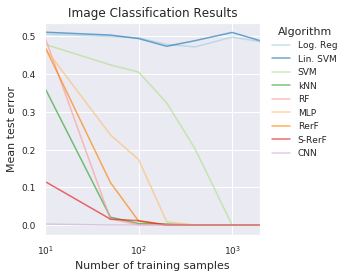

In [14]:
dat = pd.read_csv("s-rerf_runs_all_algo.csv")

d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])
#d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'se', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):
        if not cl in names.keys():
            continue

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]

        se = stats.sem(tmp['Lhat'])
        
        list(tmp.mean())
        #d1.loc[k] = [cl] + list(tmp.mean()) + [se] + [names[cl]]
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1
        
## CNN ADDON
dat2 = pd.read_csv("hvbar_cnn_results_5runs.csv")

for ni in np.unique(dat2['n']):
    for cl in np.unique(dat2['classifier']):
        if not cl in names.keys():
            continue
            
        tmp = dat2[np.logical_and(dat2['classifier'] == cl,dat2['n'] == ni)][['n', 'Lhat']]
        
        se = stats.sem(tmp['Lhat'])
        
        list(tmp.mean())
        #d1.loc[k] = [cl] + list(tmp.mean()) + [se] + [names[cl]]
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1

## Plot
fontsize = 11
sns.set(); sns.set(style="darkgrid", rc={'font.size':fontsize, 
                                         'legend.fontsize': fontsize-2,
                                         'xtick.labelsize': fontsize-2,
                                         'ytick.labelsize': fontsize-2,
                                         'axes.labelsize': fontsize})        
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']       
fig, ax = plt.subplots(figsize = (5,4))

for key in names.keys():
    grp = d1[d1['classifier'] == key] 
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], alpha =0.65)
    ax.set_xscale('log')

lgd = ax.legend(title='Algorithm', loc='upper left',bbox_to_anchor = (1.04,1), borderaxespad=0, frameon=False)
plt.title('Image Classification Results')
plt.ylabel('Mean test error')
plt.xlabel('Number of training samples')
plt.tight_layout()
#plt.savefig('./s-rerf_hvbar_experiment.pdf',format='pdf')
plt.show()

# CNN Classification

784 - [32C3-32C3-32C5S2] - [64C3-64C3-64C5S2] - 128 - 2

* 784: fully connected dense layer w/ 784 units
* 32C3: conv layer w/ 32 feature maps, 3x3 kernel, stride 1
* 32C5S2: conv layer w/ 32 feature maps, 5x5 kernel, stride 2
* etc.

with 40% dropout, batch normalization, and data augmentation added

In [7]:
import torch
import torch.nn as nn
import torch.utils.data as utils
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [15]:
# Hyperparameters
num_epochs = 100
num_classes = 2
batch_size = 200
learning_rate = 0.001
num_cnn_runs = 5

In [16]:
tensor_x = torch.from_numpy(np.reshape(X_test,(X_test.shape[0],1,28,28))).float()
tensor_y = torch.from_numpy(np.asarray(Y_test)).long()

test_tensor = utils.TensorDataset(tensor_x,tensor_y) # create your datset
test_loader = DataLoader(dataset=test_tensor, batch_size=batch_size, shuffle=False)

In [17]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear((4)**2 * 64, 200)
        self.fc2 = nn.Linear(200, 2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [20]:
def cnn_learn(n, model):
    ## Data loader
    batch_size = int(n)
    
    X = X_train[0:n, ::]
    Y = Y_train[0:n]
    
    tensor_x = torch.from_numpy(np.reshape(X,(X.shape[0],1,28,28))).float()
    tensor_y = torch.from_numpy(np.asanyarray(Y)).long()

    train_tensor = utils.TensorDataset(tensor_x,tensor_y) # create your datset

    train_loader = DataLoader(dataset=train_tensor, batch_size=batch_size, shuffle=True)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train the model
    trainStartTime = time.time()
    
    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    prior_loss = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            #images = images.float(); labels = labels.long()
            # Run the forward pass
            outputs = model(images.float())
            loss = criterion(outputs, labels.long())
            loss_list.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            if ((i + 1) % 1 == 0) and ((epoch + 1) % 5 == 0):
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                              (correct / total) * 100))
                
        if epoch > 10:
            if stats.sem(prior_loss[-5:]) < 0.001:
                break
        prior_loss.append(loss.item())
    
    trainEndTime = time.time()
    trainTime = trainEndTime - trainStartTime
    
    # Test the model
    testStartTime = time.time()
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
        testEndTime = time.time()
        testTime = testEndTime - testStartTime
        print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))
        
        lhat = 1- correct / total

        ####("variable,Lhat,trainTime,testTime,iterate")
        clf = "CNN"; iterate = 1
        
        return((clf,n,lhat,trainTime,testTime,iterate))

In [21]:
## Log output
write_path = 'hvbar_cnn_results_5runs.csv'

with open(write_path, 'w') as f:
    f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
    
runList = [(n, iterate) for n in ns\
                        for iterate in range(1, num_cnn_runs + 1)]

for n, iterate in runList:
    print(f"Size={n}, Iterate {iterate}")
    gc.collect()
    model = ConvNet()
    clf,n,lhat,trainTime,testTime,iterate = cnn_learn(n, model)
    
    with open(write_path, 'a') as f:
        f.write(f"{clf}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iterate}\n")

Size=10, Iterate 1
Epoch [5/100], Step [1/1], Loss: 0.3754, Accuracy: 100.00%
Epoch [10/100], Step [1/1], Loss: 0.0346, Accuracy: 100.00%
Epoch [15/100], Step [1/1], Loss: 0.0004, Accuracy: 100.00%
Test Accuracy of the model on the test images: 99.99 %
Size=10, Iterate 2
Epoch [5/100], Step [1/1], Loss: 0.2872, Accuracy: 100.00%
Epoch [10/100], Step [1/1], Loss: 0.0100, Accuracy: 100.00%
Epoch [15/100], Step [1/1], Loss: 0.0005, Accuracy: 100.00%
Test Accuracy of the model on the test images: 99.45 %
Size=10, Iterate 3
Epoch [5/100], Step [1/1], Loss: 0.3239, Accuracy: 100.00%
Epoch [10/100], Step [1/1], Loss: 0.0181, Accuracy: 100.00%
Epoch [15/100], Step [1/1], Loss: 0.0006, Accuracy: 100.00%
Test Accuracy of the model on the test images: 99.69 %
Size=10, Iterate 4
Epoch [5/100], Step [1/1], Loss: 0.3853, Accuracy: 100.00%
Epoch [10/100], Step [1/1], Loss: 0.0182, Accuracy: 100.00%
Epoch [15/100], Step [1/1], Loss: 0.0002, Accuracy: 100.00%
Test Accuracy of the model on the test imag